In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import torch
import torchvision
import tqdm
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader
from livelossplot import PlotLosses

from dataset import SamDataset
from test_model import *


In [3]:
dataroot = '/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD' #Change this to match the computer you are working from!
data_path=Path(dataroot, 'annotations.json')
if not data_path.is_file():
    raise(FileNotFoundError(f"File '{data_path}' doesn't exist."))
device = 'cuda' if torch.cuda.is_available() else 'cpu' # set the device according to availability

In [4]:
# %%time #uncomment this line to see how much time the cell takes to run
train_dataset = SamDataset(dataroot=dataroot, classifier='pt', split='train')
val_dataset = SamDataset(dataroot=dataroot, classifier='pt', split='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #batch size might be too small!
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Let's try to get the segments from the dataloader output

data.shape=torch.Size([32, 256, 256, 3])
permutted_data.shape=torch.Size([32, 3, 256, 256])


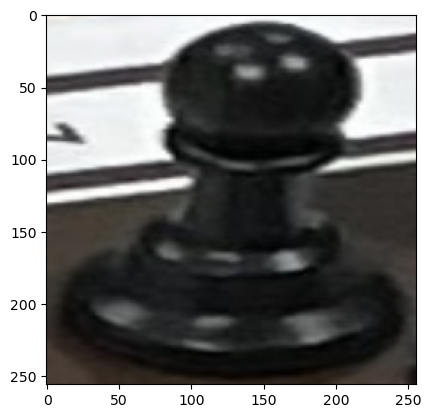

In [5]:
# cell to visualize dataloader output
for data, label in train_loader:
    print(f'{data.shape=}')
    permutted_data = data.permute(0,3,1,2)
    print(f'{permutted_data.shape=}')
    plt.imshow(permutted_data.permute(0,2,3,1)[0])
    break

In [7]:
# !nvidia-smi run this cell to see the memory utilization of the model

Show segmentation result

In [9]:
model = PieceClassifier() #create instance of model
model.to(device); #semicolon to supress output
liveloss = PlotLosses()
epochs = 1
lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create optimizer. Adam chosen almost by default, but could be changed
loss = torch.nn.CrossEntropyLoss() # create cross entropy function. Cross-entropy should be a good choice

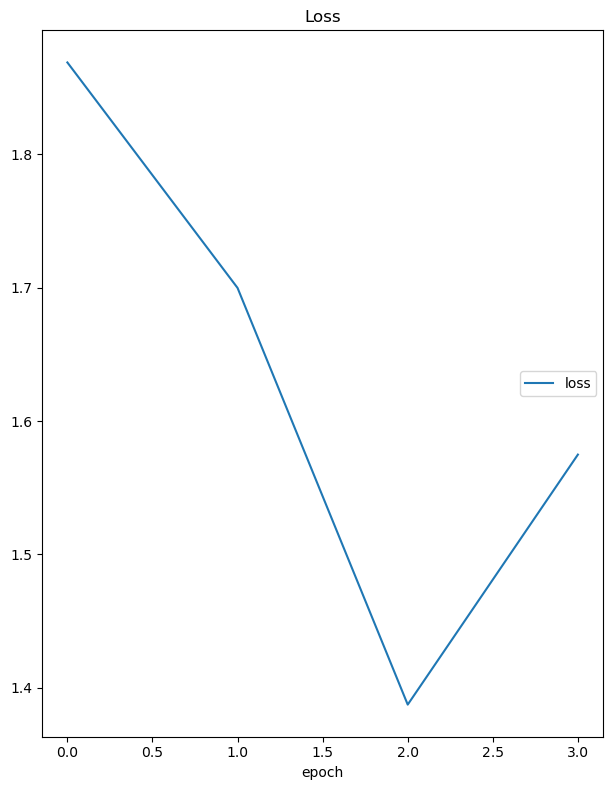

4it [00:15,  3.93s/it]

Loss
	loss             	 (min:    1.387, max:    1.869, cur:    1.575)


KeyboardInterrupt: 

In [10]:

for epoch in range(epochs):
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        crops, labels = batch # get crops and labels

        crops = crops.to(device=device) # move crops to correct device
        labels = labels.to(device=device).long() #make sure labels are numbers and not text characters
        crops = torch.moveaxis(crops, -1, 1).float() # Matching the order of the axes from the DataLoader to the model's expectations.
        IMAGENET_MEAN = [0.485, 0.456, 0.406] # mean and std for normalization of images.
        IMAGENET_STD = [0.229, 0.224, 0.225]  # required for pre-trained models, and should help new models as well.
        
        # Normalize the images using the mean and std values of the ImageNet dataset.
        normalize = torchvision.transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        crops = normalize(crops)
        # >> Zero the gradients of the optimizer
        optimizer.zero_grad()

        # >> Run the model on the imgs
        preds = model(crops)

        # >> Calculate the loss
        l = loss(preds, labels)

        # >> Propogate back the gradients from the loss to the input
        l.backward()

        # >> Apply one step of optimization the oprimixation function.        
        optimizer.step()
        
        liveloss.update({"loss": l.item()}) #should add validation loss and possibly accuracy as well!
        liveloss.draw()

In [11]:
model = AlexNetPieceClassifier() #create instance of model
model.to(device); #semicolon to supress output
liveloss = PlotLosses()
epochs = 1
lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create optimizer. Adam chosen almost by default, but could be changed
loss = torch.nn.CrossEntropyLoss() # create cross entropy function. Cross-entropy should be a good choice

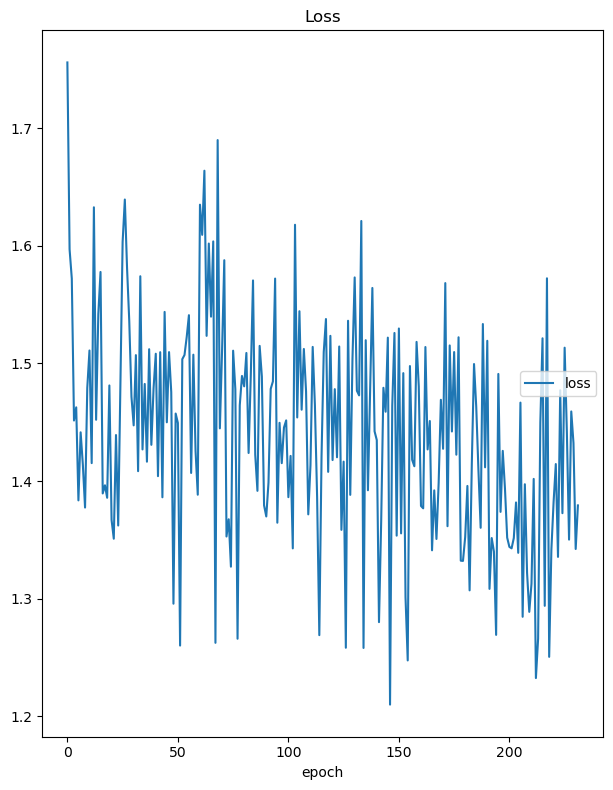

232it [13:36,  3.21s/it]

Loss
	loss             	 (min:    1.210, max:    1.756, cur:    1.379)


232it [13:39,  3.53s/it]


KeyboardInterrupt: 

In [12]:
for epoch in range(epochs):
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        crops, labels = batch # get crops and labels

        crops = crops.to(device=device) # move crops to correct device
        labels = labels.to(device=device).long() #make sure labels are numbers and not text characters
        crops = torch.moveaxis(crops, -1, 1).float() # Matching the order of the axes from the DataLoader to the model's expectations.
        IMAGENET_MEAN = [0.485, 0.456, 0.406] # mean and std for normalization of images.
        IMAGENET_STD = [0.229, 0.224, 0.225]  # required for pre-trained models, and should help new models as well.
        
        # Normalize the images using the mean and std values of the ImageNet dataset.
        normalize = torchvision.transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        crops = normalize(crops)
        # >> Zero the gradients of the optimizer
        optimizer.zero_grad()

        # >> Run the model on the imgs
        preds = model(crops)

        # >> Calculate the loss
        l = loss(preds, labels)

        # >> Propogate back the gradients from the loss to the input
        l.backward()

        # >> Apply one step of optimization the oprimixation function.        
        optimizer.step()
        
        liveloss.update({"loss": l.item()}) #should add validation loss and possibly accuracy as well!
        liveloss.draw()

In [8]:
model = torchvision.models.resnet18(pretrained=True)
liveloss = PlotLosses()
epochs = 1
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create optimizer. Adam chosen almost by default, but could be changed
loss = torch.nn.CrossEntropyLoss() # create cross entropy function. Cross-entropy should be a good choice
for param in model.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(512, 6) # assuming that the fc7 layer has 512 neurons, otherwise change it 
model.cuda();

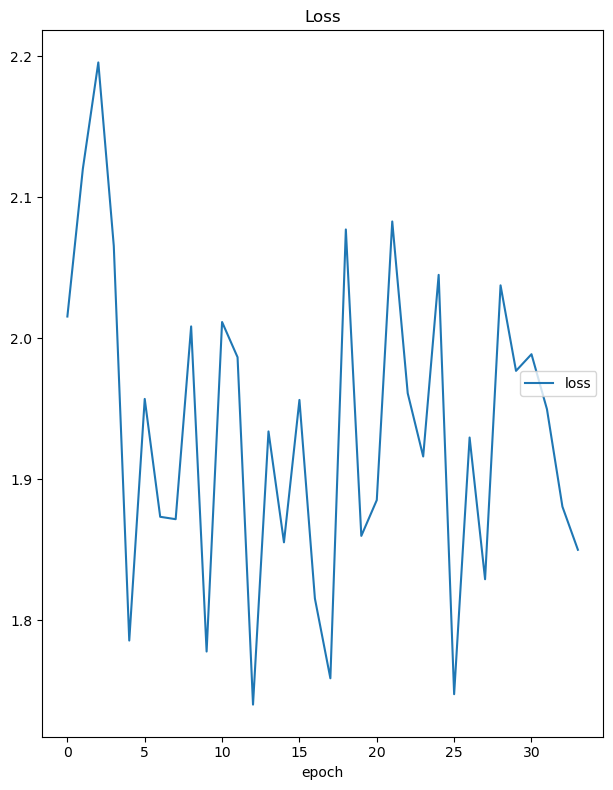

34it [01:59,  3.40s/it]

Loss
	loss             	 (min:    1.740, max:    2.196, cur:    1.850)


In [ ]:
for epoch in range(epochs):
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        crops, labels = batch # get crops and labels

        crops = crops.to(device=device) # move crops to correct device
        labels = labels.to(device=device).long() #make sure labels are numbers and not text characters
        crops = torch.moveaxis(crops, -1, 1).float() # Matching the order of the axes from the DataLoader to the model's expectations.
        IMAGENET_MEAN = [0.485, 0.456, 0.406] # mean and std for normalization of images.
        IMAGENET_STD = [0.229, 0.224, 0.225]  # required for pre-trained models, and should help new models as well.
        
        # Normalize the images using the mean and std values of the ImageNet dataset.
        normalize = torchvision.transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        crops = normalize(crops)
        # >> Zero the gradients of the optimizer
        optimizer.zero_grad()

        # >> Run the model on the imgs
        preds = model(crops)

        # >> Calculate the loss
        l = loss(preds, labels)

        # >> Propogate back the gradients from the loss to the input
        l.backward()

        # >> Apply one step of optimization the oprimixation function.        
        optimizer.step()
        
        liveloss.update({"loss": l.item()}) #should add validation loss and possibly accuracy as well!
        liveloss.draw() # The plot has "epoch" in the x-axis, but actually it plots once every BATCH! For a data point after each epoch, take this one step back in indentation
#The model doesn't seem to tain properly. I'm not sure why. Possibly making the input smaller or making it grayscale might work...